# Prepare Data

In [30]:
from google.colab import files
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import os
import sys

import librosa
import librosa.display

In [2]:
drive.mount('/content/gdrive', force_remount=True)
iemocap = "gdrive/My Drive/Public/IEMOCAP_full_release"

Mounted at /content/gdrive


# Convert into CSV

In [3]:
sessions = ["Session1", "Session2", "Session3", "Session4", "Session5"]

def convertSession(session_name):
  session_file = iemocap + "/Duration/Processed/" + session_name + ".txt"
  tokenized_lines = []

  with open(session_file) as f:
    lines = f.readlines()
    tokenizedLines = [x.split() for x in lines]

  session_csv = iemocap + "/Duration/Processed/" + session_name + ".csv"
  with open(session_csv, "w") as csv:
    audio_name = ''

    for line in tokenizedLines:
      if line[0] == "Recording":
        audio_name = line[1]
      else:
        csv.write(audio_name + ";" + line[0] + ";" + line[1] + "\n")

def convertRawToCsv():
  for session in sessions:
    convertSession(session)

# convertRawToCsv()

# Convert into data frame

In [4]:
def getSessionData(session_name):
  df = pd.read_csv(iemocap + "/Duration/Processed/" + session_name + ".csv", delimiter=";", header=None)
  df.columns = ["Audio Name", "Part", "Duration"]
  print(session_name + " count: " + str(len(df.index)))

  return df

def getDataFrame():
  result = pd.DataFrame()

  for session in sessions:
    df = getSessionData(session)
    result = result.append(df, ignore_index=True)

  return result

result = getDataFrame()
result["Duration"] = result["Duration"].apply(np.floor).astype(int)
result

Session1 count: 1819
Session2 count: 1811
Session3 count: 2136
Session4 count: 2103
Session5 count: 2170


,Audio Name,Part,Duration
0,Ses01F_impro01,F000,1
1,Ses01F_impro01,F001,1
2,Ses01F_impro01,F002,3
3,Ses01F_impro01,F003,1
4,Ses01F_impro01,F004,3
...,...,...,...
10034,Ses05M_script03_2,M041,8
10035,Ses05M_script03_2,M042,1
10036,Ses05M_script03_2,M043,2
10037,Ses05M_script03_2,M044,4


# Plot

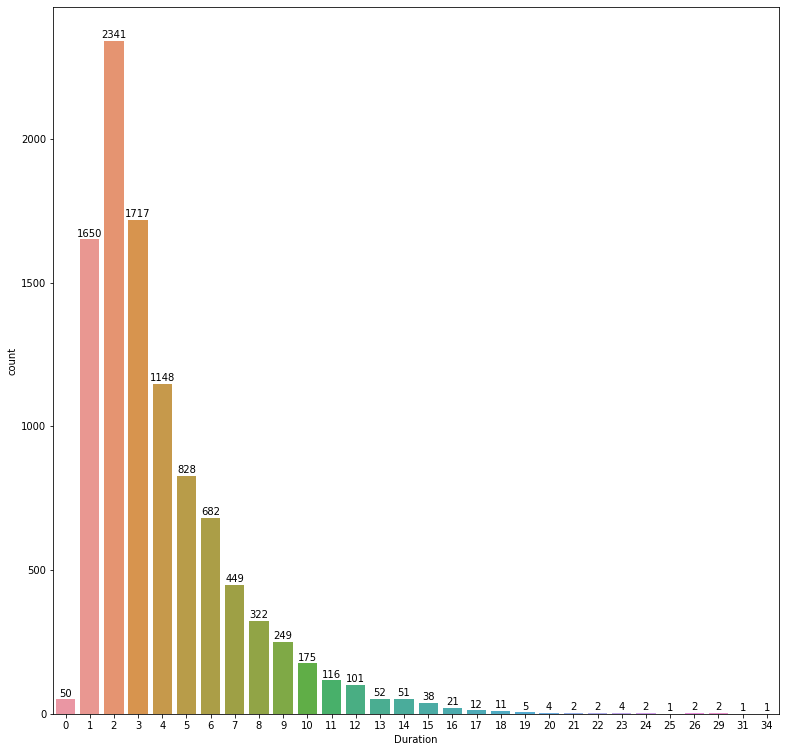

In [ ]:
plot = seaborn.countplot(x='Duration', data=result)
plot.figure.set_size_inches(13,13)

for p in plot.patches:
  height = p.get_height()
  plot.text(p.get_x() + p.get_width()/2., height + 10, '{:1.0f}'.format(height), ha="center") 

In [ ]:
print("Original data: " + str(result.count()))

count_data = result.value_counts(subset=['Duration'], sort=False).values
count_normalize = result.value_counts(subset=['Duration'], sort=False, normalize=True).values
duration = sorted(result.Duration.unique())

count_df = pd.DataFrame({"Duration": duration, "Count": count_data, "Percentage": count_normalize})
count_df.Percentage = (count_df.Percentage * 100).round(3)
count_df

Original data: Audio Name     10039
Part           10039
Duration       10039
Evaluation1        0
Evaluation2        0
Evaluation3        0
Evaluation4        0
Evaluation5        0
Evaluation6        0
Emotion        10039
dtype: int64


,Duration,Count,Percentage
0,0,50,0.498
1,1,1650,16.436
2,2,2341,23.319
3,3,1717,17.103
4,4,1148,11.435
5,5,828,8.248
6,6,682,6.794
7,7,449,4.473
8,8,322,3.207
9,9,249,2.480


# Labeling

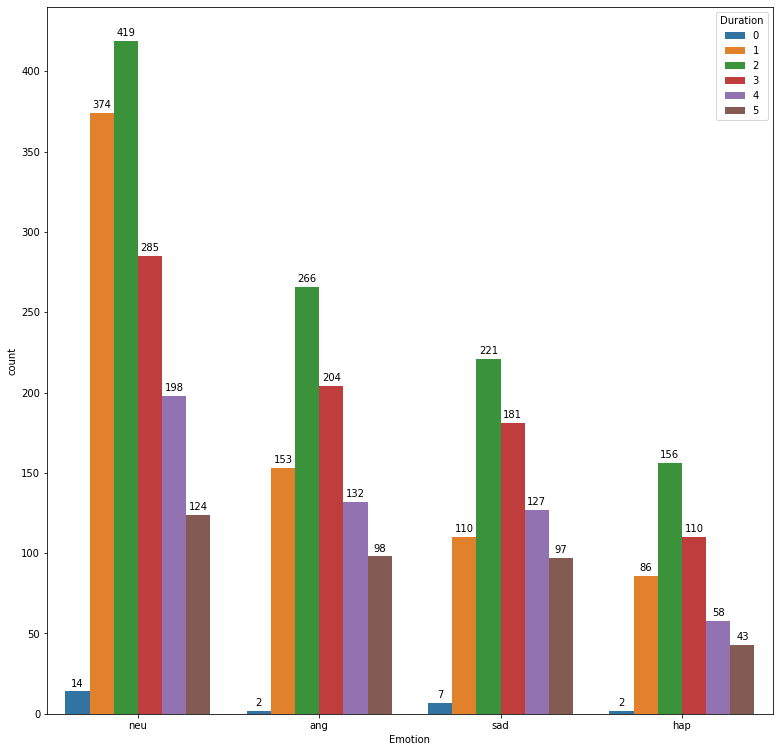

In [6]:
# emotion_column = ["Evaluation1", "Evaluation2", "Evaluation3", "Evaluation4", "Evaluation5", "Evaluation6"]

def resetEvaluation():
  # for column in emotion_column:
  #   result[column] = None

  result["Emotion"] = None

def goLabeling():
  for session in sessions:
    emotion_path = iemocap + "/" + session + "/dialog/EmoEvaluation/"

    recordings = [file.name for file in os.scandir(emotion_path) if ".txt" in file.name]
    recordings.sort()
    
    for recording in recordings:
      with open(emotion_path + recording) as f:
        lines = f.readlines()
        tokenizedLines = [x.split() for x in lines if "Ses0" in x]

        for part in tokenizedLines:
          line_name = part[3]
          line_label = part[4]
          line_queries = line_name.split("_")
          
          line_part = line_queries[-1]
          line_queries.remove(line_part)

          line_name = "_".join(line_queries)

          search_query_name = ""
          search_query_part = line_queries[-1]
          search_result = result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"]
          search_count = search_result.shape[0]
          
          if search_count == 0:
            print("ERROR: No audio part found: ")
          elif search_count > 1:
            print("ERROR: Multiple audio found: ")
          else:
            result.loc[(result["Audio Name"] == line_name) & (result["Part"] == line_part), "Emotion"] = line_label

def getClassificationReport():
  max_duration = 5

  categorical_data = result.loc[
    (result["Duration"] < max_duration + 1) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
  
  categorical_plot = seaborn.countplot(x="Emotion", hue="Duration", data=categorical_data)
  categorical_plot.figure.set_size_inches(13,13)

  for p in categorical_plot.patches:
    height = p.get_height()
    categorical_plot.text(p.get_x() + p.get_width()/2., height + 3, '{:1.0f}'.format(height), ha="center") 

  return categorical_data

# resetEvaluation()
# goLabeling()
categorical_data = getClassificationReport()

# Selection and Splitting

780
Saving 2 gdrive/My Drive/Public/IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/Ses01F_impro01_F002.wav
<class 'numpy.ndarray'>
[[-5.10218175e+02 -5.07167522e+02 -5.06234153e+02 -5.12704414e+02
  -5.13462321e+02 -5.09412772e+02 -5.06243160e+02 -5.04921622e+02
  -5.07367835e+02 -5.09008196e+02 -4.92186626e+02 -4.72977637e+02
  -4.53230046e+02 -4.31728143e+02 -4.15150763e+02 -4.09456635e+02
  -4.07105462e+02 -3.98390055e+02 -3.98853609e+02 -4.05292399e+02
  -4.12190059e+02 -4.15323900e+02 -4.24641976e+02 -4.28506835e+02
  -4.35282113e+02 -4.44591641e+02 -4.53595753e+02 -4.57703430e+02
  -4.59979834e+02 -4.68863883e+02 -4.77380316e+02 -4.80090677e+02
  -4.86844849e+02 -4.90785571e+02 -4.88796021e+02 -4.93043487e+02
  -4.94319612e+02 -4.89783838e+02 -4.78427425e+02 -4.74723068e+02
  -4.82971162e+02 -4.86128512e+02 -4.82764623e+02 -4.75001366e+02
  -4.78396246e+02 -4.80776358e+02 -4.74691490e+02 -4.71738521e+02
  -4.73426816e+02 -4.84439826e+02 -4.85926803e+02 -4.82200455e+02

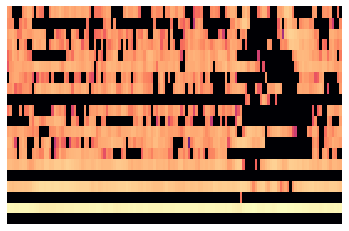

In [33]:
# Foreach dataframe
# get audio and duration
# Create different set of dataset of duration (pure and splitted), create for 1s - 5s

def checkAndCreateDirectory(filename):
  if not os.path.exists(os.path.dirname(filename)):
    try:
        os.makedirs(os.path.dirname(filename))
    except OSError as exc: # Guard against race condition
        print(exc.errno)
        if exc.errno != errno.EEXIST:
            raise

def saveImage(audio_path, audio_output):
  audio_file, sample_rate = librosa.load(audio_path)

  # Tweak: Sample Rate
  # S = librosa.feature.mfcc(y=audio_file, sr=sample_rate) # Default 22_500
  S = librosa.feature.mfcc(y=audio_file, sr=48000)

  np.set_printoptions(threshold=sys.maxsize)
  print(type(S))
  print(S)
  # TODO: Parameter MFCC, number of coefficient, Normalization
  # asd

  # Plot into image
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
  # librosa.display.specshow(librosa.power_to_db(S))
  # librosa.display.specshow(S)
  
  # Save into file
  checkAndCreateDirectory(audio_output)

  plt.gca().set_axis_off()
  plt.savefig(audio_output, dpi=100, bbox_inches='tight',pad_inches=0)
  plt.show()
  plt.clf()
  plt.close('all')

def transformAudio():
  duration_one_second = result.loc[
    (result["Duration"] == 3) &
    (
      (result["Emotion"] == 'neu') |
      (result["Emotion"] == 'ang') |
      (result["Emotion"] == 'hap') |
      (result["Emotion"] == 'sad') 
    )
  ]
    
  print(str(len(duration_one_second.index)))
  for index, row in duration_one_second.iterrows():
    audio_prefix = row["Audio Name"][:5]
    audio_session = "Error"

    if    (audio_prefix == 'Ses01'): audio_session = "Session1"
    elif  (audio_prefix == 'Ses02'): audio_session = "Session2"
    elif  (audio_prefix == 'Ses03'): audio_session = "Session3"
    elif  (audio_prefix == 'Ses04'): audio_session = "Session4"
    elif  (audio_prefix == 'Ses05'): audio_session = "Session5"

    audio_output = '/content/transformed_image/' + row['Emotion'] + '/' + row["Audio Name"] + '_' + row["Part"] + '.png'
    audio_path = iemocap + '/' + audio_session + '/sentences/wav/' + row["Audio Name"] + '/' + row["Audio Name"] + '_' + row["Part"] + '.wav'

    print("Saving " + str(index) + " " + audio_path)
    saveImage(audio_path, audio_output)
    break

def clearLocalFolder():
  !rm -rf transformed_image

def downloadLocalData():
  !zip -r /content/transformed_image.zip /content/transformed_image
  files.download("/content/transformed_image.zip")

clearLocalFolder()
transformAudio()
# downloadLocalData()

# categorical_data